In [3]:
import pandas as pd
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import os,sys
import os
import json
import xarray as xr
import numpy as np
import shapely
from shapely.geometry import Point, Polygon


import geopandas as gpd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm

from multiprocessing import Pool
from functools  import partial

import numpy
import glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
warnings.filterwarnings('ignore')
import pycountry
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
# import numbaprocess
import copy
import glob
from numba import njit
import pandas
import pickle
import matplotlib



In [8]:
def loading_WMO_regions_gpd():
    """ Getting the WMO regions json file """
    WMO_json = 'WMO_regions.json'
    if not os.path.isfile(WMO_json):
        os.system( 'wget https://cpdb.wmo.int/js/json/WMO_regions.json --no-check-certificate ')

    WMO =  gpd.read_file('WMO_regions.json')
    return WMO


# colorbar
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
        """Return a LinearSegmentedColormap
        seq: a sequence of floats and RGB-tuples. The floats should be increasing
        and in the interval (0,1).
        """
        se = [(None,) * 3, 0.0]
        for s in seq:
            se.append(s[0])
            se.append(s[1])#+ list(seq) +
            seq=se+[ (None,) * 3]
            cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
        return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
                 "rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
                 "rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
                 "rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
                 "rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
                 "rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
                 "rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
                 "rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
                 "rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))
                 
CM = make_colormap(rgblist2)

In [9]:
def read(file = '', var='ta'):
    
    df = xr.load_dataset(file).to_dataframe()
    df.reset_index(inplace=True)  
    return df
    
    


In [10]:
def make_plot_gpd(df, var, press, size, date, text=''):

#def make_plot_gpd(WMO, sc = '', database = '', date = '', what = 'a', press = 85000, size = 10 ):
    # https://stackoverflow.com/questions/59417997/how-to-plot-a-list-of-shapely-points                                                                                                                                                                                                   

    date_s = date
    date = np.datetime64(date.split('T')[0])
    
    WMO =  loading_WMO_regions_gpd()

    """ Loading from geopandas built-in methods """
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    #world = gpd.read_file('Europe_coastline.shp')
    #world = world.query( 'continent == "Europe"' )
    w = world.plot()

    h = date_s.split('T')[1]
    if h[0]=='0':
        hour = 0
    else:
        hour = 12
    """ Select data from DF """
    reduced = df.loc[ (df['pressure']==press) & (df['time']==date) & (df['hour']==hour) ]

    points_lat = reduced['lat'].values
    points_lon = reduced['lon'].values
    anomaly = reduced[ var + '_anomaly'].values
    average = reduced[ var + '_average'].values
    


        
    def plot(what = ''):
        w = world.plot()
        WMO.plot( ax=w,  facecolor="none", edgecolor="lightgray", lw = 0.8)        
        plt.xlim([-180.,180.])
        plt.ylim([-95.,95.])   
        
        if size == 10:
            marker_size = 75
        elif size == 5:
            marker_size = 17
        
        x_t = list(range(-180,181,30))
        y_t = [ -90,-70,-50,-30,-10,0,10,30,50,70,90]
        y_t_l = ['90S','70S','50S','30S','10S','0','10N','30N','50N','70N','90N']
        x_t_l = ['180W','150W','120W','90W','60W','30W','0','30E','60E','90E','120E','150E','180E']
    
        plt.xticks(x_t, x_t_l, rotation=45, fontsize = 7)
        plt.yticks(y_t, y_t_l, fontsize = 7)
        
        if what == 'anomaly':
            plt.scatter( points_lon, points_lat , c= anomaly,  s = marker_size, marker = 's', cmap='bwr', alpha = 0.8, 
                     edgecolor = 'black' , linewidths=0.3 )
            cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar        
            cbar.set_label('Temperature Anomaly over 20 years [K]')
            plt.clim(-5, 5)
            
        elif what == 'average':
            plt.scatter( points_lon, points_lat , c= average,  s = marker_size, marker = 's', cmap= CM , alpha = 0.8,
                     edgecolor = 'black' , linewidths=0.3)
        
            cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar        
            cbar.set_label('Average Temperature [K]')
            plt.clim(200, 330)
        
        
        #leg = plt.legend(fontsize = 7, loc = 'lower left', framealpha = 1, facecolor = 'lime')
        #for lh in leg.legendHandles: 
        #    lh.set_alpha(1)

        plt.title (text + ' Climate Studies using Radiosonde Data - ' + date_s + ', p=' +  str(press)[:-2] + ' [hPa] ' , fontsize = 8)
        plt.savefig(out_dir + '/ClimateChange_' + date_s + '_' + what + '_' + '_plevel_' + str(press) + '_gridsize_' + 
                    str(size) + '_' + text + '_netCDFgridded.png', dpi= 150,   bbox_inches = 'tight' )
        plt.show()
        plt.close()
        print('Done +++' , date , ' ' , what )
        
    dummy = plot(what='anomaly')
    dummy = plot(what='average')

2021-03-05 09:57:37,698 INFO Welcome to the CDS
2021-03-05 09:57:37,699 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-03-05 09:57:37,947 INFO Request is completed
2021-03-05 09:57:37,948 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1614934256.1681364-27835-7-d9c16690-40f7-4d5d-8143-7b3eadb66d83.zip to download.zip (113.5K)
2021-03-05 09:57:38,060 INFO Download rate 1023.6K/s


Request took: 0.28009510040283203 seconds


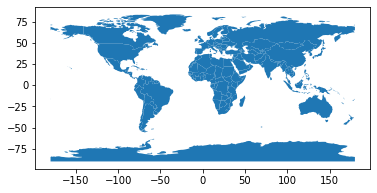

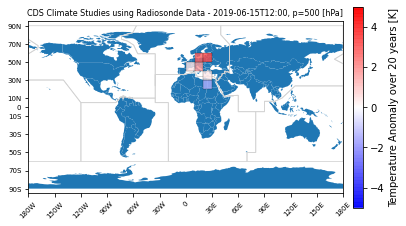

Done +++ 2019-06-15   anomaly


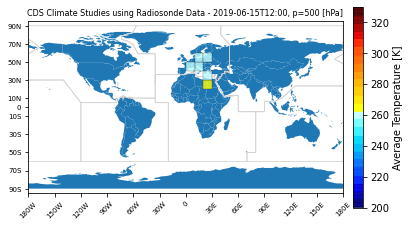

Done +++ 2019-06-15   average


In [12]:
""" Requesting data from CDS """
def request(rqdict, source='', remove_file=True):
    t0 = time.time()

    c = cdsapi.Client()
    r = c.retrieve(source, rqdict)
    print('Request took: ' + str(time.time() - t0) + ' seconds')
    if True:
        r.download(target='download.zip')
        assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./download/')
    z.close()
    
    
    file = glob.glob('./download/*.nc')[0]
    return file 
   
   

cuon = 'insitu-comprehensive-upper-air-observation-network'



#std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
plevels = [ 10000, 50000, 92500 ]


out_dir = 'Plots/CDS'
os.system('mkdir ' + out_dir )
var = 'ta'


""" Selecting the dates """
days = [ '1990-06-15T12:00' ,  '2019-06-15T12:00' ,  '2019-06-15T00:00' ]
mind, maxd = '19900615' , '20190615' 

""" Download the file from CDS """
file_cds = request({ 'variable':['temperature'],'gridded': [0,0,60,30],'date': [mind, maxd], 'time':12, 'pressure_level':500}, source=cuon, remove_file=True)
df_cds = read(file = file_cds, var='ta')
a = make_plot_gpd (df_cds , var , 50000, 10, '2019-06-15T12:00', text = 'CDS') # text will appear in the title and in the file name as extra string


2021-03-05 09:57:42,163 INFO Welcome to the CDS
2021-03-05 09:57:42,164 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-03-05 09:57:42,225 INFO Request is queued
2021-03-05 09:57:43,259 INFO Request is running
2021-03-05 09:57:44,795 INFO Request is completed
2021-03-05 09:57:44,796 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1614934664.1816258-28135-7-91ba3315-3b46-477e-a7fc-fbb7bd16d55d.zip to download.zip (1.7M)
 10%|█         | 185k/1.74M [00:00<00:00, 1.87MB/s]

Request took: 2.6610445976257324 seconds


2021-03-05 09:57:45,236 INFO Download rate 4M/s     


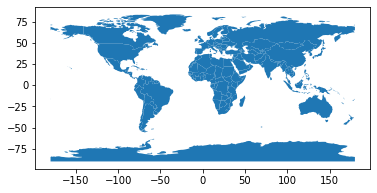

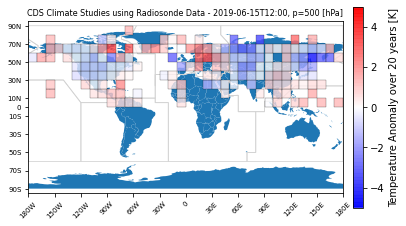

Done +++ 2019-06-15   anomaly


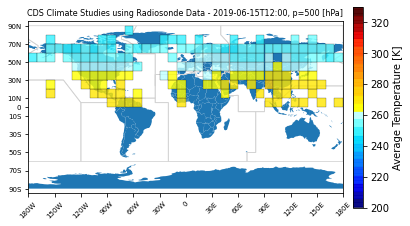

Done +++ 2019-06-15   average


In [13]:
file_cds = request({ 'variable':['temperature'],'gridded': [0,-180,90,180],'date': [mind, maxd], 'time':12, 'pressure_level':500}, source=cuon, remove_file=True)
df_cds = read(file = file_cds, var='ta')
a = make_plot_gpd (df_cds , var , 50000, 10, '2019-06-15T12:00', text = 'CDS') # text will appear in the title and in the file name as extra string


2021-03-05 09:58:04,010 INFO Welcome to the CDS
2021-03-05 09:58:04,011 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-03-05 09:58:04,077 INFO Request is queued
2021-03-05 09:58:05,112 INFO Request is running
2021-03-05 09:58:06,646 INFO Request is completed
2021-03-05 09:58:06,646 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1614934686.1276386-23770-13-1158df04-e697-48f1-b102-8e9d549e2146.zip to download.zip (1.7M)
 11%|█         | 197k/1.74M [00:00<00:00, 1.99MB/s]

Request took: 2.6648263931274414 seconds


2021-03-05 09:58:06,896 INFO Download rate 7M/s     


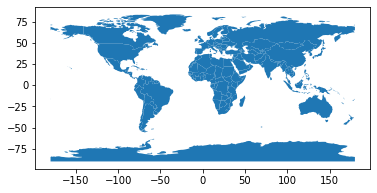

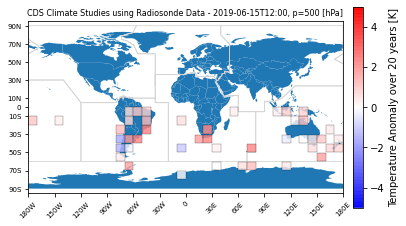

Done +++ 2019-06-15   anomaly


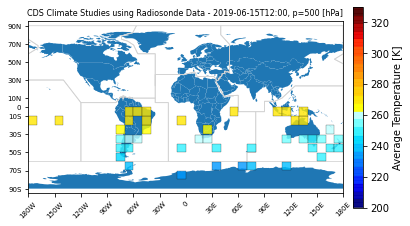

Done +++ 2019-06-15   average


In [14]:
file_cds = request({ 'variable':['temperature'],'gridded': [-90,-180,0,180],'date': [mind, maxd], 'time':12, 'pressure_level':500}, source=cuon, remove_file=True)
df_cds = read(file = file_cds, var='ta')
a = make_plot_gpd (df_cds , var , 50000, 10, '2019-06-15T12:00', text = 'CDS') # text will appear in the title and in the file name as extra string
